In [7]:
from transition_analsyis_functions import (extract_and_normalize_t1_data, add_columns_from_excel, logistic_regression_cv, print_excel_columns_all_sheets, assign_group, count_cluster_changes, get_transition_changes)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [8]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

def lasso_regression_analysis(
    df,
    target_column,
    ignore_columns=None,
    alpha_range=None,
    cv_folds=5,
    standardize=True,
    plot_results=True
):
    """
    Perform Lasso linear regression with cross-validation.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    target_column : str
        Name of the target column to predict
    ignore_columns : list, optional
        List of column names to ignore (e.g., ['subject_code', 'after'])
        If None, only the target_column will be excluded
    alpha_range : list, optional
        Range of alpha values to test. If None, uses LassoCV default range
    cv_folds : int, default=5
        Number of cross-validation folds
    standardize : bool, default=True
        Whether to standardize features before regression
    plot_results : bool, default=True
        Whether to plot coefficient importance and cross-validation results
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'model': Fitted Lasso model
        - 'scaler': StandardScaler (if standardize=True)
        - 'best_alpha': Best alpha value
        - 'coefficients': DataFrame with feature coefficients
        - 'cv_scores': Cross-validation scores
        - 'X_train': Feature matrix
        - 'y_train': Target vector
        - 'feature_names': List of feature names
    """
    
    # Make a copy to avoid modifying original
    df_work = df.copy()
    
    # Validate target column exists
    if target_column not in df_work.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataframe. "
                        f"Available columns: {list(df_work.columns)}")
    
    # Determine columns to ignore
    if ignore_columns is None:
        ignore_columns = []
    elif isinstance(ignore_columns, str):
        ignore_columns = [ignore_columns]
    
    # Ensure target_column is in ignore list
    if target_column not in ignore_columns:
        ignore_columns = ignore_columns + [target_column]
    
    # Get feature columns (all columns except ignored ones)
    feature_columns = [col for col in df_work.columns if col not in ignore_columns]
    
    if len(feature_columns) == 0:
        raise ValueError("No feature columns available after ignoring specified columns.")
    
    print(f"="*70)
    print(f"Lasso Regression Analysis")
    print(f"="*70)
    print(f"Target column: {target_column}")
    print(f"Ignored columns: {ignore_columns}")
    print(f"Feature columns ({len(feature_columns)}): {feature_columns}")
    print()
    
    # Prepare data
    X = df_work[feature_columns].copy()
    y = df_work[target_column].copy()
    
    # Remove rows with NaN in target or features
    mask = ~(y.isna() | X.isna().any(axis=1))
    X = X[mask].copy()
    y = y[mask].copy()
    
    print(f"Data shape: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Target variable: {target_column}")
    print(f"  Mean: {y.mean():.4f}, Std: {y.std():.4f}")
    print()
    
    # Standardize features if requested
    scaler = None
    if standardize:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_train = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)
    else:
        X_train = X
    
    # Find optimal alpha using cross-validation
    if alpha_range is None:
        # Use LassoCV to find optimal alpha
        print("Finding optimal alpha using LassoCV...")
        lasso_cv = LassoCV(
            alphas=np.logspace(-4, 1, 50),  # Range from 0.0001 to 10
            cv=cv_folds,
            random_state=42,
            max_iter=2000
        )
        lasso_cv.fit(X_train, y)
        best_alpha = lasso_cv.alpha_
        print(f"Optimal alpha: {best_alpha:.6f}")
    else:
        # Use provided alpha range
        print(f"Testing alpha range: {alpha_range}")
        lasso_cv = LassoCV(
            alphas=alpha_range,
            cv=cv_folds,
            random_state=42,
            max_iter=2000
        )
        lasso_cv.fit(X_train, y)
        best_alpha = lasso_cv.alpha_
        print(f"Optimal alpha: {best_alpha:.6f}")
    
    # Fit final model with best alpha
    print("\nFitting final Lasso model...")
    model = Lasso(alpha=best_alpha, max_iter=2000, random_state=42)
    model.fit(X_train, y)
    
    # Cross-validation scores
    print("\nPerforming cross-validation...")
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y, cv=kf, scoring='r2')
    cv_mse = -cross_val_score(model, X_train, y, cv=kf, scoring='neg_mean_squared_error')
    cv_mae = -cross_val_score(model, X_train, y, cv=kf, scoring='neg_mean_absolute_error')
    
    # Predictions
    y_pred = model.predict(X_train)
    
    # Calculate metrics
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mse)
    
    # Print results
    print(f"\n{'='*70}")
    print("Model Performance")
    print(f"{'='*70}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print()
    print(f"Cross-Validation Results ({cv_folds}-fold):")
    print(f"  R²: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"  RMSE: {np.sqrt(cv_mse).mean():.4f} (+/- {np.sqrt(cv_mse).std()*2:.4f})")
    print(f"  MAE: {cv_mae.mean():.4f} (+/- {cv_mae.std()*2:.4f})")
    
    # Create coefficients dataframe
    coefficients_df = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient': model.coef_,
        'Abs_Coefficient': np.abs(model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    # Count non-zero coefficients
    n_nonzero = np.sum(model.coef_ != 0)
    print(f"\nNon-zero coefficients: {n_nonzero} / {len(feature_columns)}")
    
    # Print top coefficients
    print(f"\n{'='*70}")
    print("Feature Coefficients (sorted by absolute value)")
    print(f"{'='*70}")
    print(coefficients_df.to_string(index=False))
    
    # Plotting
    if plot_results:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Coefficient importance
        ax1 = axes[0, 0]
        top_n = min(15, len(coefficients_df))
        top_coefs = coefficients_df.head(top_n)
        colors = ['red' if c < 0 else 'blue' for c in top_coefs['Coefficient']]
        ax1.barh(range(len(top_coefs)), top_coefs['Coefficient'], color=colors)
        ax1.set_yticks(range(len(top_coefs)))
        ax1.set_yticklabels(top_coefs['Feature'])
        ax1.set_xlabel('Coefficient Value', fontsize=12)
        ax1.set_title(f'Top {top_n} Feature Coefficients (Lasso, α={best_alpha:.4f})', fontsize=14, fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
        ax1.grid(axis='x', alpha=0.3)
        ax1.invert_yaxis()
        
        # 2. Predicted vs Actual
        ax2 = axes[0, 1]
        ax2.scatter(y, y_pred, alpha=0.6, s=50)
        min_val = min(y.min(), y_pred.min())
        max_val = max(y.max(), y_pred.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
        ax2.set_xlabel(f'Actual {target_column}', fontsize=12)
        ax2.set_ylabel(f'Predicted {target_column}', fontsize=12)
        ax2.set_title(f'Predicted vs Actual (R² = {r2:.4f})', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        # 3. Residuals plot
        ax3 = axes[1, 0]
        residuals = y - y_pred
        ax3.scatter(y_pred, residuals, alpha=0.6, s=50)
        ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax3.set_xlabel('Predicted Values', fontsize=12)
        ax3.set_ylabel('Residuals', fontsize=12)
        ax3.set_title('Residual Plot', fontsize=14, fontweight='bold')
        ax3.grid(alpha=0.3)
        
        # 4. Cross-validation scores
        ax4 = axes[1, 1]
        ax4.bar(range(1, cv_folds+1), cv_scores, alpha=0.7, color='steelblue')
        ax4.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {cv_scores.mean():.4f}')
        ax4.set_xlabel('CV Fold', fontsize=12)
        ax4.set_ylabel('R² Score', fontsize=12)
        ax4.set_title(f'Cross-Validation R² Scores ({cv_folds}-fold)', fontsize=14, fontweight='bold')
        ax4.set_xticks(range(1, cv_folds+1))
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Return results
    results = {
        'model': model,
        'scaler': scaler,
        'best_alpha': best_alpha,
        'coefficients': coefficients_df,
        'cv_scores': cv_scores,
        'cv_mse': cv_mse,
        'cv_mae': cv_mae,
        'r2': r2,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'X_train': X_train,
        'y_train': y,
        'y_pred': y_pred,
        'feature_names': feature_columns,
        'n_nonzero_coefs': n_nonzero
    }
    
    return results


In [9]:
# Example 1: Predict 'after' using brain network features
# Ignore 'subject_code' column
results_after = lasso_regression_analysis(
    df=df,
    target_column='after',
    ignore_columns=['subject_code'],
    cv_folds=5,
    standardize=True,
    plot_results=True
)


NameError: name 'df' is not defined

In [ ]:
# Example 2: Predict a different target (e.g., 'DMN_GM') using other features
# Ignore 'subject_code' and 'after' columns
# results_dmn = lasso_regression_analysis(
#     df=df,
#     target_column='DMN_GM',
#     ignore_columns=['subject_code', 'after'],
#     cv_folds=5,
#     standardize=True,
#     plot_results=True
# )

# Example 3: Custom alpha range
# results_custom = lasso_regression_analysis(
#     df=df,
#     target_column='after',
#     ignore_columns=['subject_code'],
#     alpha_range=np.logspace(-3, 0, 20),  # Custom range
#     cv_folds=10,
#     standardize=True,
#     plot_results=True
# )


Loading file: only_Q_outputs/combined/T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 9
Columns: ['subject_code', 'after', 'DMN_GM', 'DAN_GM', 'FPN_GM', 'LIM_GM', 'SMN_GM', 'VAN_GM', 'VIS_GM']

Target distribution (after):
  after = 0.0: 55 subjects (72.4%)
  after = 1.0: 21 subjects (27.6%)

Preparing features and target...
Feature columns (7): ['DMN_GM', 'DAN_GM', 'FPN_GM', 'LIM_GM', 'SMN_GM', 'VAN_GM', 'VIS_GM']

Valid subjects (after removing missing): 76
Removed 0 subjects with missing values
Target classes: [np.float64(0.0), np.float64(1.0)]

Preparing data for cross-validation...
Data prepared: (76, 7)

LOGISTIC REGRESSION: Binary Classification with SMOTE Upsampling
Target: after
Features: 7 columns
Cross-validation: 5-fold stratified
Upsampling: Enabled (SMOTE)

--- Fold 1/5 ---
  Training data before upsampling: 60 samples
  Training data after upsampling: 88 samples
  Class distribution after upsampling: {np.float

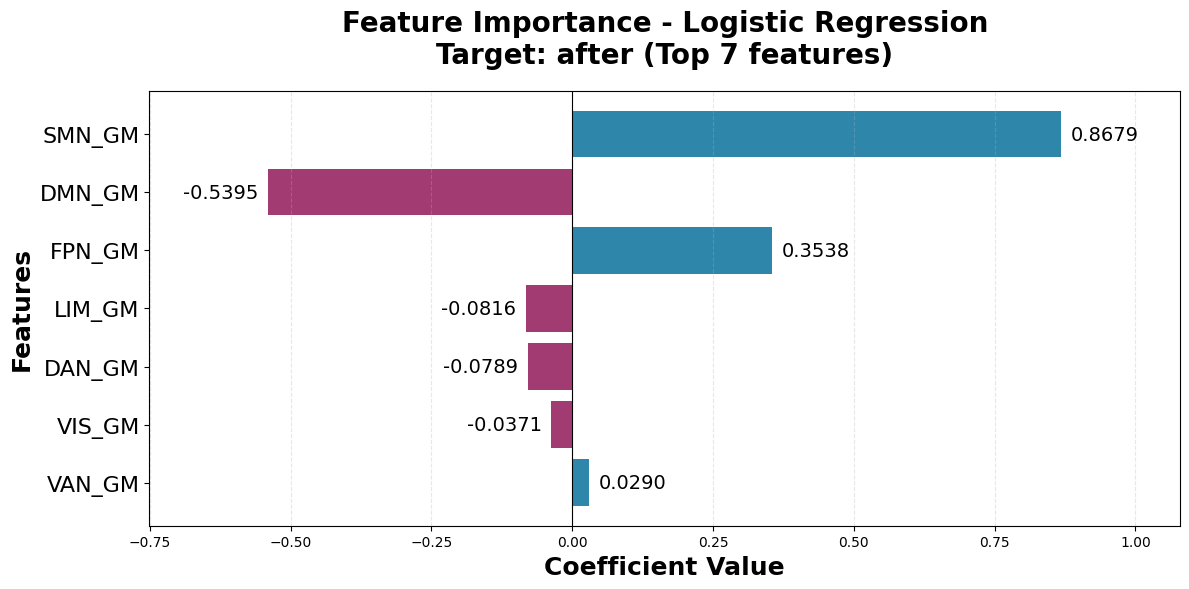


Results saved to: only_Q_outputs/combined/logistic_regression_cv_results.csv
Feature importance saved to: only_Q_outputs/combined/logistic_regression_cv_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.6067 (+/- 0.0830)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.000022  0.500000   0.333333     0.6  0.428571  0.490909       60   
1     2  0.135682  0.733333   0.500000     0.5  0.500000  0.727273       61   
2     3  0.026699  0.600000   0.333333     0.5  0.400000  0.386364       61   
3     4  0.011989  0.600000   0.333333     0.5  0.400000  0.636364       61   
4     5  0.035474  0.600000   0.333333     0.5  0.400000  0.636364       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   roc_auc
0    

In [ ]:
# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"only_Q_outputs/combined/T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path=None,  # Uses default path if None
    verbose=True,
    top_n_features=10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])


Loading file: only_Q_outputs/combined/T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 9
Columns: ['subject_code', 'after', 'DMN_GM', 'DAN_GM', 'FPN_GM', 'LIM_GM', 'SMN_GM', 'VAN_GM', 'VIS_GM']

Target distribution (after):
  after = 0.0: 55 subjects (72.4%)
  after = 1.0: 21 subjects (27.6%)

Preparing features and target...
Feature columns (7): ['DMN_GM', 'DAN_GM', 'FPN_GM', 'LIM_GM', 'SMN_GM', 'VAN_GM', 'VIS_GM']

Valid subjects (after removing missing): 76
Removed 0 subjects with missing values
Target classes: [np.float64(0.0), np.float64(1.0)]

Preparing data for cross-validation...
Data prepared: (76, 7)

LOGISTIC REGRESSION: Binary Classification with SMOTE Upsampling
Target: after
Features: 7 columns
Cross-validation: 5-fold stratified
Upsampling: Enabled (SMOTE)

--- Fold 1/5 ---
  Training data before upsampling: 60 samples
  Training data after upsampling: 88 samples
  Class distribution after upsampling: {np.float

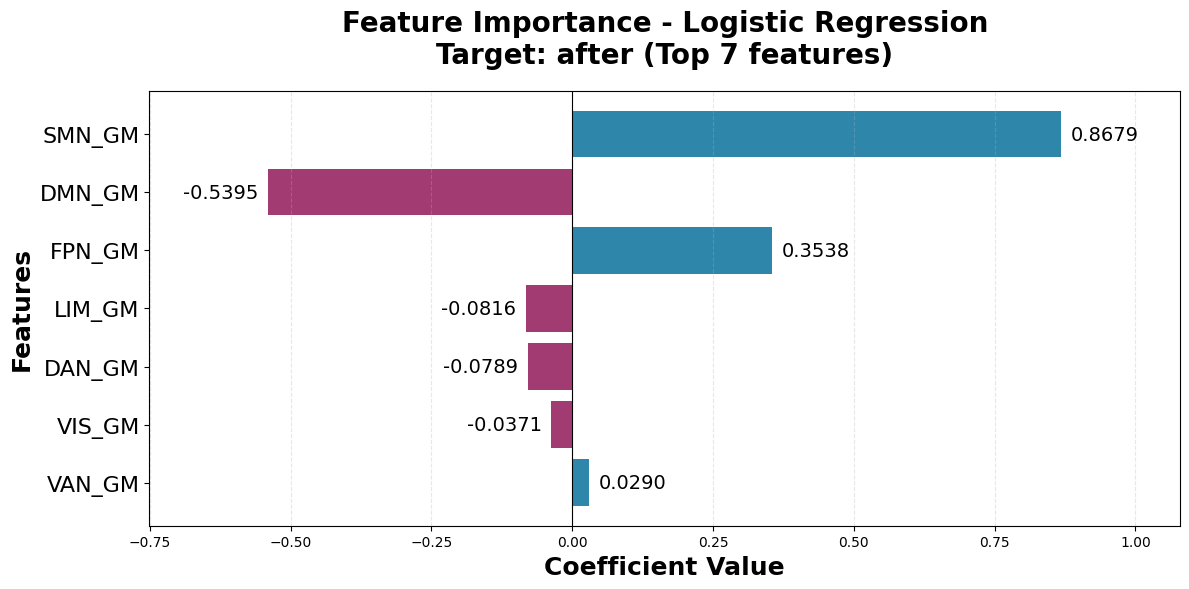


Results saved to: only_Q_outputs/combined/networks_logistic_regression_results.csv
Feature importance saved to: only_Q_outputs/combined/networks_logistic_regression_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.6067 (+/- 0.0830)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.000022  0.500000   0.333333     0.6  0.428571  0.490909       60   
1     2  0.135682  0.733333   0.500000     0.5  0.500000  0.727273       61   
2     3  0.026699  0.600000   0.333333     0.5  0.400000  0.386364       61   
3     4  0.011989  0.600000   0.333333     0.5  0.400000  0.636364       61   
4     5  0.035474  0.600000   0.333333     0.5  0.400000  0.636364       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   r

In [ ]:
# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"only_Q_outputs/combined/T1_networks_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path="only_Q_outputs/combined/networks_logistic_regression_results.csv",  # Uses default path if None
    verbose=True,
    top_n_features=10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])


Loading file: only_Q_outputs/combined\T1_networks_parcels_68_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 70
Columns: ['subject_code', 'after', 'bankssts_lh', 'bankssts_rh', 'caudalanteriorcingulate_lh', 'caudalanteriorcingulate_rh', 'caudalmiddlefrontal_lh', 'caudalmiddlefrontal_rh', 'cuneus_lh', 'cuneus_rh', 'entorhinal_lh', 'entorhinal_rh', 'frontalpole_lh', 'frontalpole_rh', 'fusiform_lh', 'fusiform_rh', 'inferiorparietal_lh', 'inferiorparietal_rh', 'inferiortemporal_lh', 'inferiortemporal_rh', 'insula_lh', 'insula_rh', 'isthmuscingulate_lh', 'isthmuscingulate_rh', 'lateraloccipital_lh', 'lateraloccipital_rh', 'lateralorbitofrontal_lh', 'lateralorbitofrontal_rh', 'lingual_lh', 'lingual_rh', 'medialorbitofrontal_lh', 'medialorbitofrontal_rh', 'middletemporal_lh', 'middletemporal_rh', 'paracentral_lh', 'paracentral_rh', 'parahippocampal_lh', 'parahippocampal_rh', 'parsopercularis_lh', 'parsopercularis_rh', 'parsorbitalis_lh', 'parsorbi

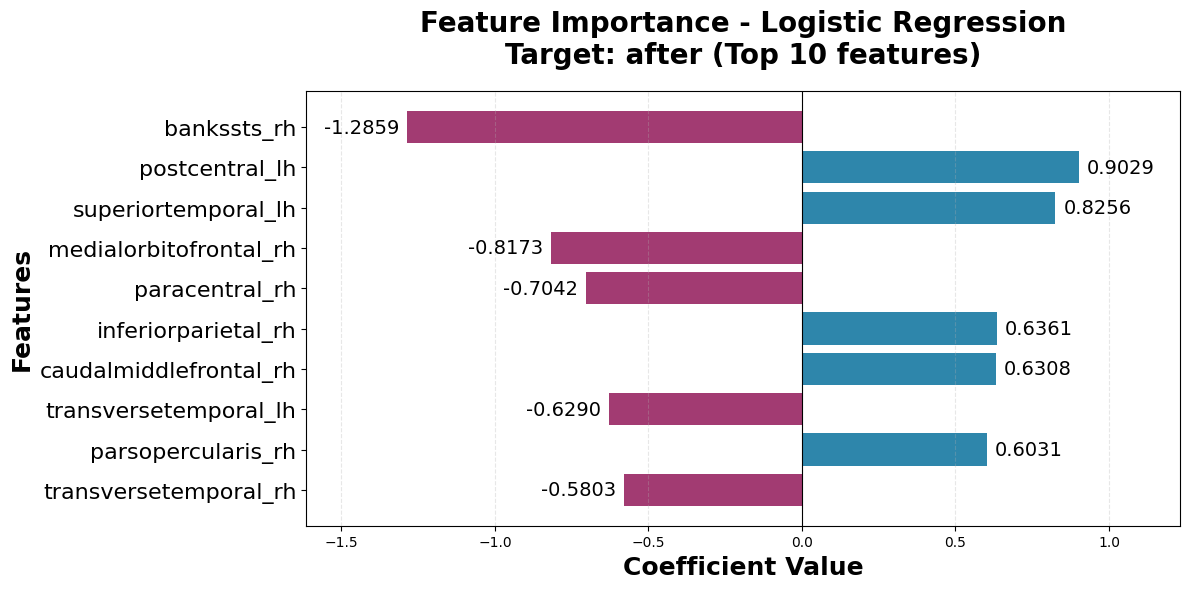


Results saved to: only_Q_outputs/combined/logistic_regression_cv_results.csv
Feature importance saved to: only_Q_outputs/combined/logistic_regression_cv_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.7350 (+/- 0.1355)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.621755  0.875000   0.800000     0.8  0.800000  0.981818       60   
1     2  0.036960  0.800000   0.666667     0.5  0.571429  0.681818       61   
2     3  0.011074  0.533333   0.285714     0.5  0.363636  0.568182       61   
3     4  0.134696  0.800000   0.666667     0.5  0.571429  0.636364       61   
4     5  0.004779  0.666667   0.000000     0.0  0.000000  0.636364       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   roc_auc
0    

In [ ]:

# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"only_Q_outputs/combined\T1_networks_parcels_68_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path=None,  # Uses default path if None
    verbose=True,
    top_n_features=10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])


Loading file: only_Q_outputs/combined/T1_networks_parcels_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 36
Columns: ['subject_code', 'after', 'bankssts_lh', 'bankssts_rh', 'caudalanteriorcingulate_lh', 'caudalanteriorcingulate_rh', 'caudalmiddlefrontal_lh', 'caudalmiddlefrontal_rh', 'fusiform_lh', 'fusiform_rh', 'inferiortemporal_lh', 'inferiortemporal_rh', 'isthmuscingulate_lh', 'isthmuscingulate_rh', 'middletemporal_lh', 'middletemporal_rh', 'paracentral_lh', 'paracentral_rh', 'postcentral_lh', 'postcentral_rh', 'posteriorcingulate_lh', 'posteriorcingulate_rh', 'precentral_lh', 'precentral_rh', 'precuneus_lh', 'precuneus_rh', 'rostralanteriorcingulate_lh', 'rostralanteriorcingulate_rh', 'rostralmiddlefrontal_lh', 'rostralmiddlefrontal_rh', 'superiorfrontal_lh', 'superiorfrontal_rh', 'superiortemporal_lh', 'superiortemporal_rh', 'transversetemporal_lh', 'transversetemporal_rh']

Target distribution (after):
  after = 0.0: 55 subjects (72

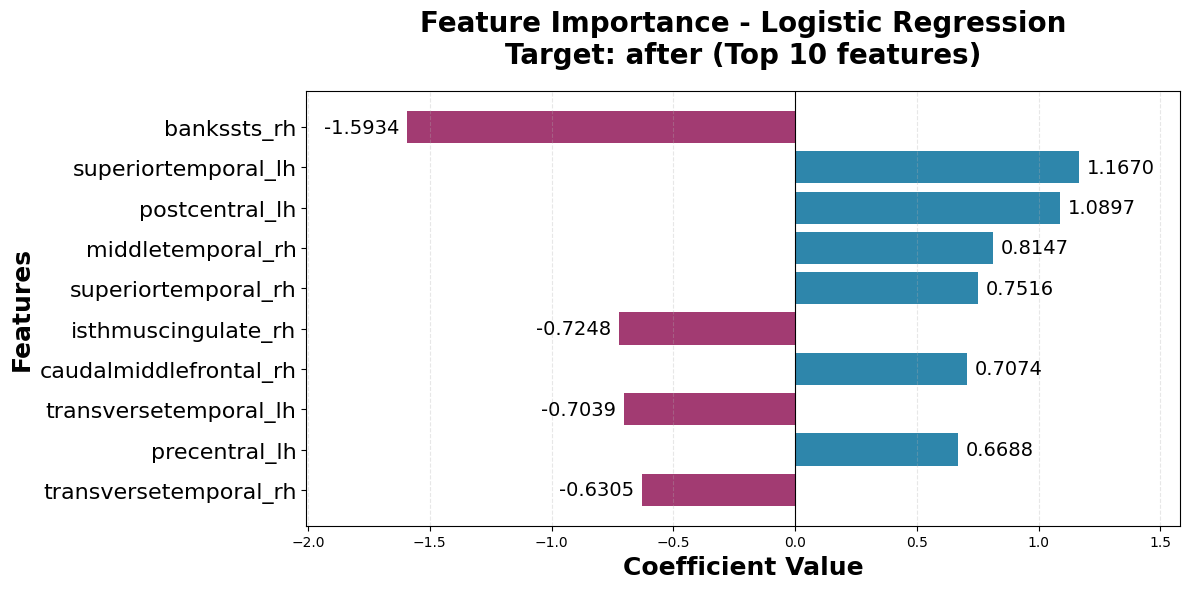


Results saved to: only_Q_outputs/combined/logistic_regression_cv_results.csv
Feature importance saved to: only_Q_outputs/combined/logistic_regression_cv_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.6300 (+/- 0.0820)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.310370  0.750000   0.571429    0.80  0.666667  0.854545       60   
1     2  0.024473  0.600000   0.250000    0.25  0.250000  0.659091       61   
2     3  0.019474  0.533333   0.285714    0.50  0.363636  0.659091       61   
3     4  0.047112  0.666667   0.333333    0.25  0.285714  0.659091       61   
4     5  0.000578  0.600000   0.000000    0.00  0.000000  0.681818       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   roc_auc
0    

In [ ]:

# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"only_Q_outputs/combined/T1_networks_parcels_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path=None,  # Uses default path if None
    verbose=True,
    top_n_features= 10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])


Loading file: only_Q_outputs/combined/T1_subcortex_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 47
Columns: ['subject_code', 'after', '3rd_ventricle', '4th_ventricle', '5th_ventricle', 'brain_stem', 'cc_anterior', 'cc_central', 'cc_mid_anterior', 'cc_mid_posterior', 'cc_posterior', 'csf', 'left_accumbens_area', 'left_amygdala', 'left_caudate', 'left_cerebellum_cortex', 'left_cerebellum_white_matter', 'left_choroid_plexus', 'left_hippocampus', 'left_inf_lat_vent', 'left_lateral_ventricle', 'left_non_wm_hypointensities', 'left_pallidum', 'left_putamen', 'left_thalamus', 'left_ventraldc', 'left_vessel', 'left_wm_hypointensities', 'non_wm_hypointensities', 'optic_chiasm', 'right_accumbens_area', 'right_amygdala', 'right_caudate', 'right_cerebellum_cortex', 'right_cerebellum_white_matter', 'right_choroid_plexus', 'right_hippocampus', 'right_inf_lat_vent', 'right_lateral_ventricle', 'right_non_wm_hypointensities', 'right_pallidum', 'right_

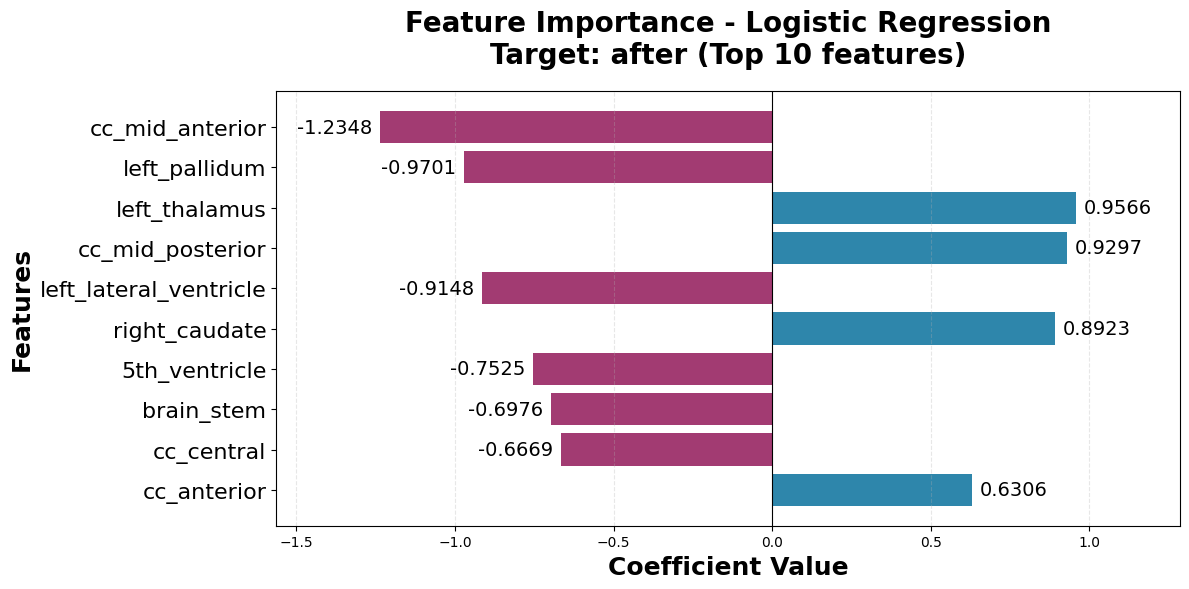


Results saved to: only_Q_outputs/combined/logistic_regression_cv_results.csv
Feature importance saved to: only_Q_outputs/combined/logistic_regression_cv_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.5400 (+/- 0.0596)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.074812  0.500000   0.000000     0.0  0.000000  0.436364       60   
1     2  0.167588  0.600000   0.000000     0.0  0.000000  0.136364       61   
2     3  0.007749  0.600000   0.333333     0.5  0.400000  0.545455       61   
3     4  0.007193  0.533333   0.000000     0.0  0.000000  0.568182       61   
4     5  0.006400  0.466667   0.250000     0.5  0.333333  0.500000       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   roc_auc
0    

In [ ]:

# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"only_Q_outputs/combined/T1_subcortex_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path=None,  # Uses default path if None
    verbose=True,
    top_n_features= 10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])


Loading file: only_Q_outputs\combined\T1_subcortex_and_cortex_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 115
Columns: ['subject_code', 'after', '3rd_ventricle', '4th_ventricle', '5th_ventricle', 'brain_stem', 'cc_anterior', 'cc_central', 'cc_mid_anterior', 'cc_mid_posterior', 'cc_posterior', 'csf', 'left_accumbens_area', 'left_amygdala', 'left_caudate', 'left_cerebellum_cortex', 'left_cerebellum_white_matter', 'left_choroid_plexus', 'left_hippocampus', 'left_inf_lat_vent', 'left_lateral_ventricle', 'left_non_wm_hypointensities', 'left_pallidum', 'left_putamen', 'left_thalamus', 'left_ventraldc', 'left_vessel', 'left_wm_hypointensities', 'non_wm_hypointensities', 'optic_chiasm', 'right_accumbens_area', 'right_amygdala', 'right_caudate', 'right_cerebellum_cortex', 'right_cerebellum_white_matter', 'right_choroid_plexus', 'right_hippocampus', 'right_inf_lat_vent', 'right_lateral_ventricle', 'right_non_wm_hypointensities', 'right_pallidum', 'righ

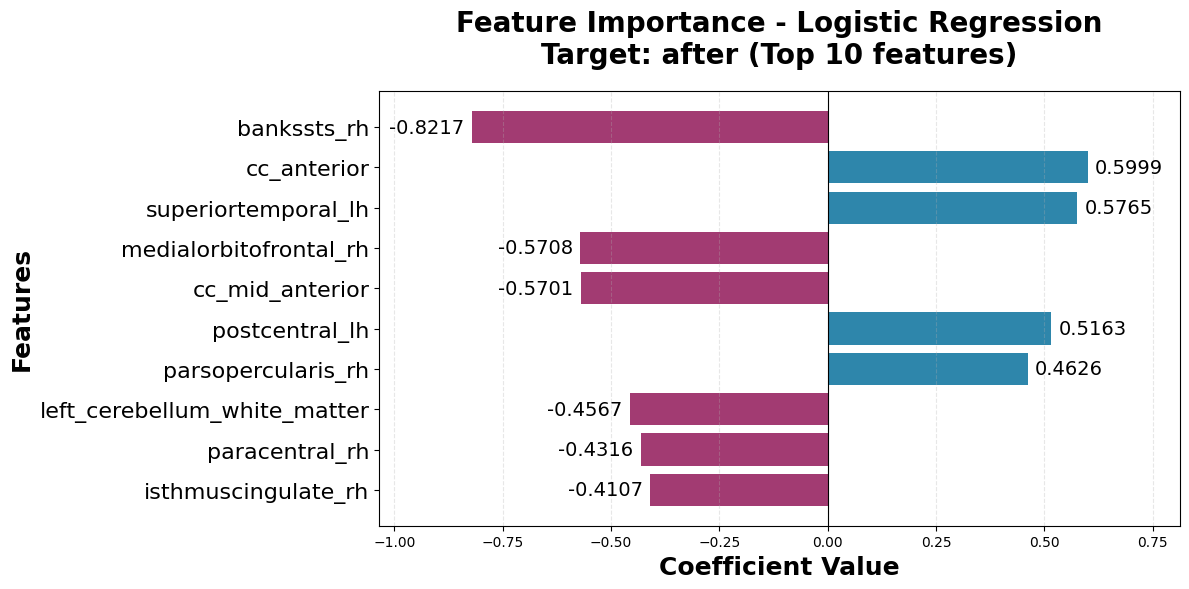


Results saved to: only_Q_outputs/combined/logistic_regression_cv_results.csv
Feature importance saved to: only_Q_outputs/combined/logistic_regression_cv_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.6042 (+/- 0.1188)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.117782  0.687500   0.500000    0.40  0.444444  0.781818       60   
1     2  0.000160  0.666667   0.333333    0.25  0.285714  0.545455       61   
2     3  0.000229  0.400000   0.142857    0.25  0.181818  0.590909       61   
3     4  0.015757  0.666667   0.333333    0.25  0.285714  0.500000       61   
4     5  0.001010  0.600000   0.250000    0.25  0.250000  0.522727       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   roc_auc
0    

In [ ]:

# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"only_Q_outputs\combined\T1_subcortex_and_cortex_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path=None,  # Uses default path if None
    verbose=True,
    top_n_features= 10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])


Loading file: C:\Users\nogag\PycharmProjects\technion\only_Q_outputs\combined\T1_lobes_lr_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 14
Columns: ['subject_code', 'after', 'cingulate_lh', 'cingulate_rh', 'frontal_lh', 'frontal_rh', 'parietal_lh', 'parietal_rh', 'temporal_lh', 'temporal_rh', 'occipital_lh', 'occipital_rh', 'insula_lh', 'insula_rh']

Target distribution (after):
  after = 0.0: 55 subjects (72.4%)
  after = 1.0: 21 subjects (27.6%)

Preparing features and target...
Feature columns (12): ['cingulate_lh', 'cingulate_rh', 'frontal_lh', 'frontal_rh', 'parietal_lh', 'parietal_rh', 'temporal_lh', 'temporal_rh', 'occipital_lh', 'occipital_rh', 'insula_lh', 'insula_rh']

Valid subjects (after removing missing): 76
Removed 0 subjects with missing values
Target classes: [np.float64(0.0), np.float64(1.0)]

Preparing data for cross-validation...
Data prepared: (76, 12)

LOGISTIC REGRESSION: Binary Classification with SMOTE Upsampling
Target: af

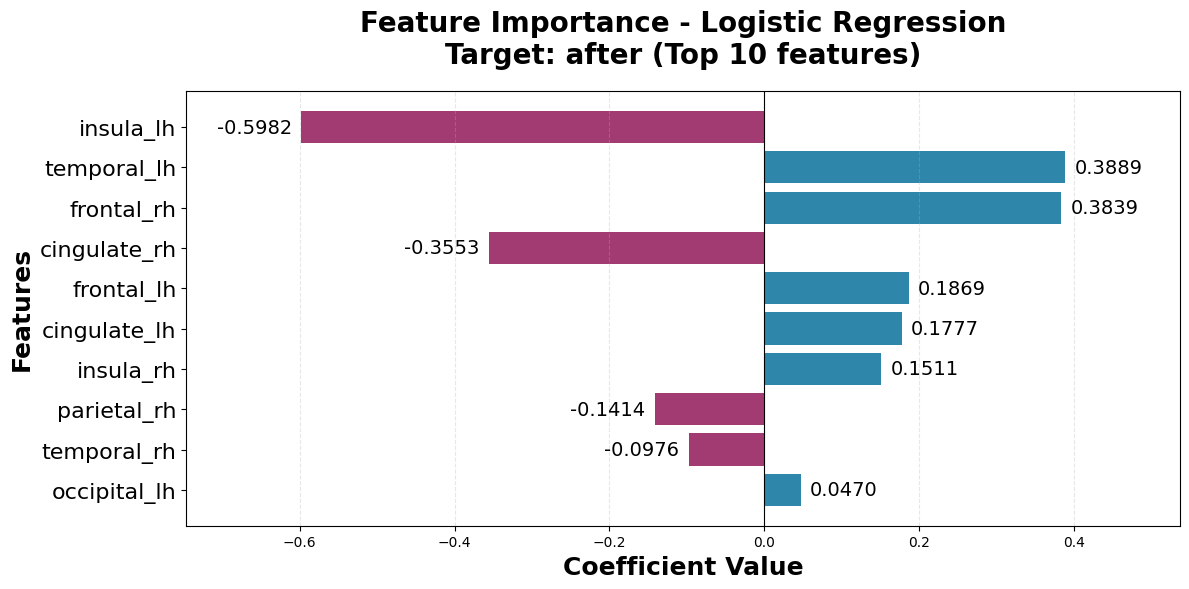


Results saved to: only_Q_outputs/combined/logistic_regression_cv_results.csv
Feature importance saved to: only_Q_outputs/combined/logistic_regression_cv_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.4350 (+/- 0.0929)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.090944     0.375   0.000000    0.00  0.000000  0.309091       60   
1     2  0.005350     0.600   0.250000    0.25  0.250000  0.522727       61   
2     3  0.022818     0.400   0.222222    0.50  0.307692  0.409091       61   
3     4  0.021926     0.400   0.142857    0.25  0.181818  0.386364       61   
4     5  0.200677     0.400   0.000000    0.00  0.000000  0.181818       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   roc_auc
0    

In [12]:

# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"C:\Users\nogag\PycharmProjects\technion\only_Q_outputs\combined\T1_lobes_lr_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path=None,  # Uses default path if None
    verbose=True,
    top_n_features= 10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])


Loading file: C:\Users\nogag\PycharmProjects\technion\only_Q_outputs\combined\T1_lobes_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv
Loaded 76 subjects
Total columns: 8
Columns: ['subject_code', 'after', 'cingulate', 'frontal', 'parietal', 'temporal', 'occipital', 'insula']

Target distribution (after):
  after = 0.0: 55 subjects (72.4%)
  after = 1.0: 21 subjects (27.6%)

Preparing features and target...
Feature columns (6): ['cingulate', 'frontal', 'parietal', 'temporal', 'occipital', 'insula']

Valid subjects (after removing missing): 76
Removed 0 subjects with missing values
Target classes: [np.float64(0.0), np.float64(1.0)]

Preparing data for cross-validation...
Data prepared: (76, 6)

LOGISTIC REGRESSION: Binary Classification with SMOTE Upsampling
Target: after
Features: 6 columns
Cross-validation: 5-fold stratified
Upsampling: Enabled (SMOTE)

--- Fold 1/5 ---
  Training data before upsampling: 60 samples
  Training data after upsampling: 88 samples
  Class d

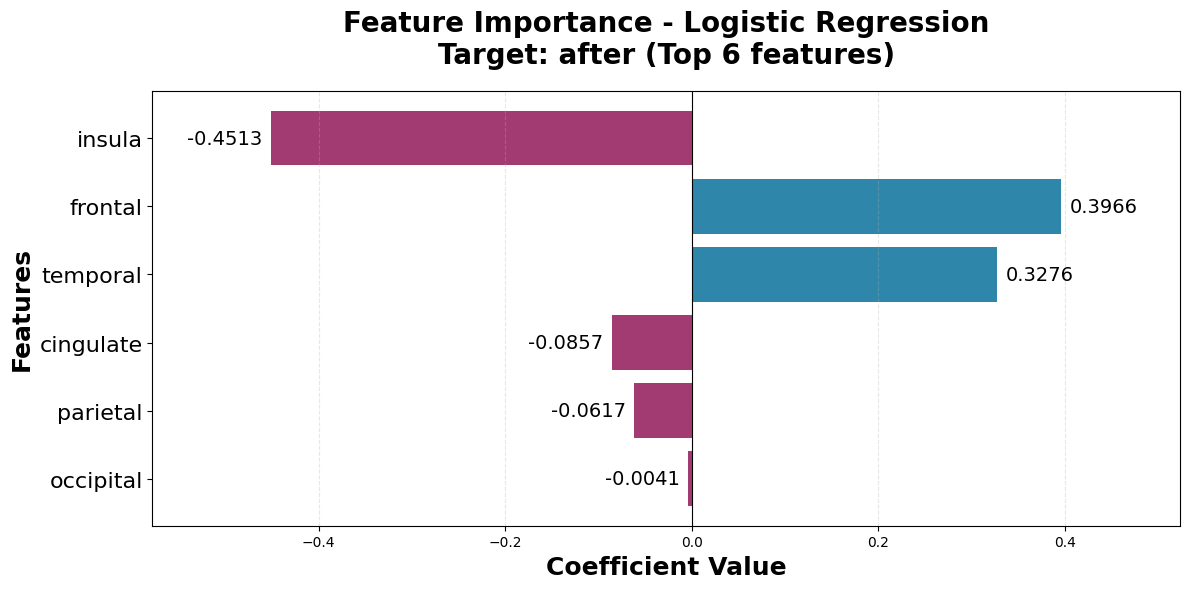


Results saved to: only_Q_outputs/combined/logistic_regression_cv_results.csv
Feature importance saved to: only_Q_outputs/combined/logistic_regression_cv_results_feature_importance.csv

ACCESSING RESULTS:
Mean Accuracy: 0.4900 (+/- 0.1730)

Full Results DataFrame:
   fold        r2  accuracy  precision  recall        f1   roc_auc  n_train  \
0     1  0.200089  0.250000   0.111111    0.20  0.142857  0.181818       60   
1     2  0.012624  0.733333   0.500000    0.50  0.500000  0.568182       61   
2     3  0.002677  0.466667   0.250000    0.50  0.333333  0.477273       61   
3     4  0.004370  0.533333   0.200000    0.25  0.222222  0.363636       61   
4     5  0.241159  0.466667   0.166667    0.25  0.200000  0.181818       61   

   n_train_final  n_test  
0             88      16  
1             88      15  
2             88      15  
3             88      15  
4             88      15  

Summary Table with Mean:
   fold        r2  accuracy  precision  recall        f1   roc_auc
0    

In [11]:

# Example call to logistic_regression_cv function
results = logistic_regression_cv(
    input_file_path=r"C:\Users\nogag\PycharmProjects\technion\only_Q_outputs\combined\T1_lobes_all_brain_all_subjects_with_after_normalized_by_etiv_NO_NAN.csv",
    subject_col="subject_code",
    target_col="after",
    n_folds=5,
    cv_random_state=42,
    results_save_path=None,  # Uses default path if None
    verbose=True,
    top_n_features= 10,  # Show top 10 features in visualization, or None for all
    use_upsampling = True
)

# Access results
print("\n" + "="*70)
print("ACCESSING RESULTS:")
print("="*70)
print(f"Mean Accuracy: {results['mean_accuracy']:.4f} (+/- {results['std_accuracy']:.4f})")
# Display full results dataframe
print("\nFull Results DataFrame:")
print(results['results_df'])

# Display summary table with mean row
print("\nSummary Table with Mean:")
print(results['display_df'])


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

def classical_linear_regression(
    file_path,
    target_column,
    ignore_columns=None,
    standardize=True,
    cv_folds=5,
    plot_results=True
):
    """
    Perform classical linear regression (Ordinary Least Squares).
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing T1 columns and target columns
    target_column : str
        Name of the target column to predict
    ignore_columns : list, optional
        List of column names to ignore (e.g., ['subject_code'])
        If None, only the target_column will be excluded
    standardize : bool, default=True
        Whether to standardize features before regression
    cv_folds : int, default=5
        Number of cross-validation folds
    plot_results : bool, default=True
        Whether to plot results
    
    Returns:
    --------
    dict : Dictionary containing:
        - 'model': Fitted LinearRegression model
        - 'scaler': StandardScaler (if standardize=True)
        - 'coefficients': DataFrame with feature coefficients
        - 'cv_scores': Cross-validation scores
        - 'X_train': Feature matrix
        - 'y_train': Target vector
        - 'feature_names': List of feature names
    """
    
    # Load the data
    print(f"="*70)
    print(f"Loading data from: {file_path}")
    print(f"="*70)
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} rows, {len(df.columns)} columns")
    print(f"Columns: {list(df.columns)}")
    print()
    
    # Validate target column exists
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataframe. "
                        f"Available columns: {list(df.columns)}")
    
    # Determine columns to ignore
    if ignore_columns is None:
        ignore_columns = []
    elif isinstance(ignore_columns, str):
        ignore_columns = [ignore_columns]
    
    # Ensure target_column is in ignore list
    if target_column not in ignore_columns:
        ignore_columns = ignore_columns + [target_column]
    
    # Get feature columns (all columns except ignored ones)
    feature_columns = [col for col in df.columns if col not in ignore_columns]
    
    if len(feature_columns) == 0:
        raise ValueError("No feature columns available after ignoring specified columns.")
    
    print(f"Target column: {target_column}")
    print(f"Ignored columns: {ignore_columns}")
    print(f"Feature columns ({len(feature_columns)}): {feature_columns}")
    print()
    
    # Prepare data
    X = df[feature_columns].copy()
    y = df[target_column].copy()
    
    # Remove rows with NaN in target or features
    mask = ~(y.isna() | X.isna().any(axis=1))
    X = X[mask].copy()
    y = y[mask].copy()
    
    print(f"Data shape: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"Target variable: {target_column}")
    print(f"  Mean: {y.mean():.4f}, Std: {y.std():.4f}")
    print()
    
    # Standardize features if requested
    scaler = None
    if standardize:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_train = pd.DataFrame(X_scaled, columns=feature_columns, index=X.index)
    else:
        X_train = X
    
    # Fit linear regression model
    print("Fitting Linear Regression model...")
    model = LinearRegression()
    model.fit(X_train, y)
    
    # Cross-validation scores
    print(f"\nPerforming {cv_folds}-fold cross-validation...")
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train, y, cv=kf, scoring='r2')
    cv_mse = -cross_val_score(model, X_train, y, cv=kf, scoring='neg_mean_squared_error')
    cv_mae = -cross_val_score(model, X_train, y, cv=kf, scoring='neg_mean_absolute_error')
    
    # Predictions
    y_pred = model.predict(X_train)
    
    # Calculate metrics
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mse)
    
    # Print results
    print(f"\n{'='*70}")
    print("Model Performance")
    print(f"{'='*70}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print()
    print(f"Cross-Validation Results ({cv_folds}-fold):")
    print(f"  R²: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"  RMSE: {np.sqrt(cv_mse).mean():.4f} (+/- {np.sqrt(cv_mse).std()*2:.4f})")
    print(f"  MAE: {cv_mae.mean():.4f} (+/- {cv_mae.std()*2:.4f})")
    
    # Create coefficients dataframe
    coefficients_df = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient': model.coef_,
        'Abs_Coefficient': np.abs(model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(f"\n{'='*70}")
    print("Feature Coefficients (sorted by absolute value)")
    print(f"{'='*70}")
    print(coefficients_df.to_string(index=False))
    
    # Plotting
    if plot_results:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Coefficient importance
        ax1 = axes[0, 0]
        top_n = min(15, len(coefficients_df))
        top_coefs = coefficients_df.head(top_n)
        colors = ['red' if c < 0 else 'blue' for c in top_coefs['Coefficient']]
        ax1.barh(range(len(top_coefs)), top_coefs['Coefficient'], color=colors)
        ax1.set_yticks(range(len(top_coefs)))
        ax1.set_yticklabels(top_coefs['Feature'])
        ax1.set_xlabel('Coefficient Value', fontsize=12)
        ax1.set_title(f'Top {top_n} Feature Coefficients (Linear Regression)', fontsize=14, fontweight='bold')
        ax1.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
        ax1.grid(axis='x', alpha=0.3)
        ax1.invert_yaxis()
        
        # 2. Predicted vs Actual
        ax2 = axes[0, 1]
        ax2.scatter(y, y_pred, alpha=0.6, s=50)
        min_val = min(y.min(), y_pred.min())
        max_val = max(y.max(), y_pred.max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
        ax2.set_xlabel(f'Actual {target_column}', fontsize=12)
        ax2.set_ylabel(f'Predicted {target_column}', fontsize=12)
        ax2.set_title(f'Predicted vs Actual (R² = {r2:.4f})', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        # 3. Residuals plot
        ax3 = axes[1, 0]
        residuals = y - y_pred
        ax3.scatter(y_pred, residuals, alpha=0.6, s=50)
        ax3.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax3.set_xlabel('Predicted Values', fontsize=12)
        ax3.set_ylabel('Residuals', fontsize=12)
        ax3.set_title('Residual Plot', fontsize=14, fontweight='bold')
        ax3.grid(alpha=0.3)
        
        # 4. Cross-validation scores
        ax4 = axes[1, 1]
        ax4.bar(range(1, cv_folds+1), cv_scores, alpha=0.7, color='steelblue')
        ax4.axhline(y=cv_scores.mean(), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {cv_scores.mean():.4f}')
        ax4.set_xlabel('CV Fold', fontsize=12)
        ax4.set_ylabel('R² Score', fontsize=12)
        ax4.set_title(f'Cross-Validation R² Scores ({cv_folds}-fold)', fontsize=14, fontweight='bold')
        ax4.set_xticks(range(1, cv_folds+1))
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # Return results
    results = {
        'model': model,
        'scaler': scaler,
        'coefficients': coefficients_df,
        'cv_scores': cv_scores,
        'cv_mse': cv_mse,
        'cv_mae': cv_mae,
        'r2': r2,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'X_train': X_train,
        'y_train': y,
        'y_pred': y_pred,
        'feature_names': feature_columns
    }
    
    return results

# Example usage:
# results = classical_linear_regression(
#     file_path=r"path/to/your/file.csv",
#     target_column='after',  # Specify your target column
#     ignore_columns=['subject_code'],  # Specify columns to ignore
#     standardize=True,
#     cv_folds=5,
#     plot_results=True
# )


In [ ]:
# Example: Run classical linear regression
# Modify the file_path, target_column, and ignore_columns as needed

results = classical_linear_regression(
    file_path=r"path/to/your/file.csv",  # Replace with your file path
    target_column='after',  # Specify which column is your target
    ignore_columns=['subject_code'],  # Specify which columns to ignore
    standardize=True,  # Standardize features (recommended)
    cv_folds=5,  # Number of cross-validation folds
    plot_results=True  # Show plots
)

# Access results if needed:
# print(f"R² Score: {results['r2']:.4f}")
# print(f"RMSE: {results['rmse']:.4f}")
# print(f"\nCoefficients:\n{results['coefficients']}")
